### Data Challenge '17

+ Given the time series of the x, y, z accelerometer readings from a cell phone, identify the activity that the user is executing
+ Sampling rate: 20Hz (1 sample every 50ms, generally but not always the case)
+ The acceleration recorded includes gravitational acceleration toward the center of the Earth, so that when the phone is at rest on a flat surface the vertical axis will register +10 or -10.
+ 2,000,000 train examples
+ 836,011 unlabeled examples 

In [16]:
import pandas as pd
root_dir = "C:/Users/rarez/Documents/Data Science/human_activity/data/"

train_raw_data = pd.read_csv(root_dir + "train_raw.csv")

train_raw_data.head(10)


,id,timestamp,activity,x,y,z
0,304,1370520469556,Walking,0.294132,-0.635605,-0.226936
1,304,1370520469606,Walking,-0.499688,-0.604451,-0.226020
2,304,1370520469656,Walking,-2.178345,0.713491,0.372017
3,304,1370520469706,Walking,-2.797763,1.354899,-0.277638
4,304,1370520469756,Walking,-2.167961,-1.327716,-0.554971
5,304,1370520469806,Walking,-1.734857,0.818559,-0.165544
6,304,1370520469856,Walking,-1.463939,0.835969,0.411112
7,304,1370520469906,Walking,-0.945008,1.085202,0.395230
8,304,1370520469956,Walking,0.182038,0.281303,0.534202
9,304,1370520470006,Walking,0.948368,0.078496,0.564745


In [23]:
grouped = train_raw_data.groupby('activity').size()
grouped = round(100*grouped/len(train_raw_data),2)
grouped

activity
Jogging      14.74
LyingDown    10.81
Sitting      24.86
Stairs        1.71
Standing      8.93
Walking      38.96
dtype: float64

### Algorithm
+ XGBoost - extremely fast implementation of Gradient Boosting Machines (boosted trees)

### Methodology 
+ 25 seconds rolling windows with no overlapping

### Features
+ 38 features
+ First 4 moments (mean, variance, skewness, kurtosis) of x, y, z, magnitude (||a||) and their derivatives (32 features)
+ 3 correlations and 3 eigenvalues of correlation matrix (6 features)



### Cross Validation

Using simple Stratified K-Folds (folds are made by preserving the percentage of samples for each class) to generate train and test splits in cross-validation can lead to artificially high accuracies:


Group K-Folds cross-validation is fundamental in this case to guarantee that samples are really independent
+ Activity examples are highly correlated for each individual user
+ Each user id is considered a different group
+ Group K-Folds guarantees that, in a given split, no user id appears simultaneously in train and test sets

Accuracy results are very different when we start testing our model using examples that it has actually never seen before:

In [76]:
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold

root_dir = "C:/Users/rarez/Documents/Data Science/human_activity/data/"

train_dirt_data = pd.read_csv(root_dir + "train_dirt.csv")
train_data = pd.read_csv(root_dir + "train.csv")

activities = {0 : "Jogging", 1 : "LyingDown", 2 : "Sitting",
              3 : "Stairs" , 4 : "Standing",  5 : "Walking"}

In [77]:
param = dict()
param['objective'] = 'multi:softmax'
param['num_class'] = 6
param['updater'] = 'grow_gpu_hist'
param['max_depth'] = 6
param['min_child_weight'] = 0
param['gamma'] = 0
param['reg_lambda'] = 1
param['reg_alpha'] = 0
param['subsample'] = 0.5
param['colsample_bytree'] = 0.5
param['learning_rate'] = 0.3
num_round = 100

'''
X = train_dirt_data.loc[:, 'mean_x':].values
y = train_dirt_data.loc[:, 'activity_id'].values
groups = train_dirt_data.loc[:, 'user_id'].values    
'''
X = train_data.loc[:, 'mean_x':].values
y = train_data.loc[:, 'activity_id'].values
groups = train_data.loc[:, 'user_id'].values    

#skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 31416)
gkf = GroupKFold(n_splits=4)


scores_test = []
scores_train = []
accuracy = []
for i in range(6):
    accuracy.append(list())
    
#for train_index, test_index in skf.split(X, y):
for train_index, test_index in gkf.split(X, y, groups):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    classifier = xgb.train(param, dtrain, num_round)

    dpred = xgb.DMatrix(X_train)
    y_pred = classifier.predict(dpred)
    scores_train.append(accuracy_score(y_train, y_pred))

    dpred = xgb.DMatrix(X_test)
    y_pred = classifier.predict(dpred)
    scores_test.append(accuracy_score(y_test, y_pred))
    
    for i in range(6):
        accuracy[i].append(sum((y_pred == i) & (y_pred == y_test))/sum(y_test == i))
    
scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

for i in range(6):
    accuracy[i] = np.array(accuracy[i])
    

print("Train set accuracy: {:.3f} (+/- {:.3f})".format(scores_train.mean(), scores_train.std()))
print("Test set accuracy:  {:.3f} (+/- {:.3f})".format(scores_test.mean(), scores_test.std()))
print()
print("Folds accuracy:")
print(scores_test)
print()
for i in range(6):
    print("Test set accuracy for {}: {:.3f} ({})".format(i, accuracy[i].mean(), activities[i]))

print()    
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
    

Train set accuracy: 1.000 (+/- 0.000)
Test set accuracy:  0.826 (+/- 0.007)

Folds accuracy:
[ 0.82663092  0.81636608  0.83693224  0.82602862]

Test set accuracy for 0: 0.948 (Jogging)
Test set accuracy for 1: 0.064 (LyingDown)
Test set accuracy for 2: 0.747 (Sitting)
Test set accuracy for 3: 0.004 (Stairs)
Test set accuracy for 4: 0.746 (Standing)
Test set accuracy for 5: 0.926 (Walking)

Confusion Matrix:
[[1370    0   40    1    4  142]
 [   0    1  140    0    9    3]
 [   2   91  679    0  130  133]
 [  40    0    0    0    0   76]
 [   1    1   39    0  338   44]
 [ 129    8   57   17   60 3153]]


Let's investigate the user composition of the first fold:

In [50]:
gkf = list(GroupKFold(n_splits=4).split(X, y, groups))

train_index, test_index = gkf[0]

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

Counter(train_dirt_data.iloc[test_index]['user_id'])

Counter({115: 263,
         130: 21,
         175: 119,
         209: 88,
         219: 27,
         220: 100,
         223: 11,
         227: 28,
         239: 112,
         246: 39,
         249: 212,
         262: 20,
         302: 310,
         320: 98,
         326: 72,
         332: 48,
         341: 49,
         349: 117,
         352: 131,
         358: 7390})

In [45]:
train_358 = train_dirt_data.iloc[test_index]
train_358 = train_358[train_358.user_id==358]
train_358.loc[:,'user_id':'mean_mag'].head(12)

,user_id,activity_id,win_begin_idx,win_end_idx,mean_x,mean_y,mean_z,mean_mag
6751,358,4,337550,337599,0.004387,0.033789,0.555472,0.652046
6752,358,4,337600,337649,-0.020275,0.066181,-0.015809,0.473797
6753,358,4,337650,337699,-0.010263,0.004197,0.011564,0.069590
6754,358,4,337700,337749,0.004581,-0.032034,0.011826,0.162264
6755,358,4,337750,337799,0.054165,0.017917,0.000031,0.122356
6756,358,4,337800,337849,-0.060561,-0.010397,0.008699,0.376230
6757,358,4,337850,337899,-0.001491,-0.064459,0.004740,0.139017
6758,358,4,337900,337949,0.015088,0.011008,0.020641,0.316159
6759,358,4,337950,337999,-0.030262,0.006512,0.016426,0.128551
6760,358,4,338000,338049,-0.013421,-0.036212,-0.003879,0.209843


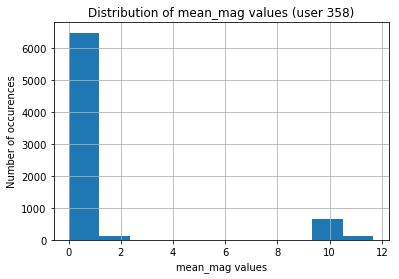

In [62]:
import matplotlib.pyplot as plt

plt.hist(train_358['mean_mag'])

plt.xlabel('mean_mag values')
plt.ylabel('Number of occurences')
plt.title('Distribution of mean_mag values (user 358)')
plt.grid(True)
plt.show()


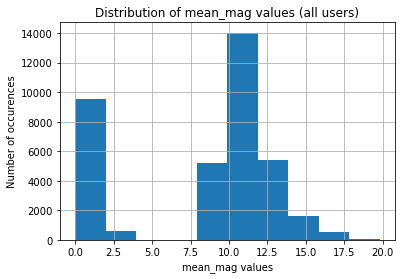

In [72]:
plt.hist(train_dirt_data['mean_mag'])

plt.xlabel('mean_mag values')
plt.ylabel('Number of occurences')
plt.title('Distribution of mean_mag values (all users)')
plt.grid(True)
plt.show()


In [74]:
print('Unfortunately, almost 30% of the training data is just noise!')
print()
print('Total number of samples: {}'.format(len(train_dirt_data)))
print('Number of samples with mean_mag < 5: {}'.format(len(train_dirt_data[train_dirt_data.mean_mag<5])))
perc = 100*len(train_dirt_data[train_dirt_data.mean_mag<5])/len(train_dirt_data)
print('Percentage of unusable training samples: {:.2f}%'.format(perc))

Unfortunately, almost 30% of the training data is just noise!

Total number of samples: 37031
Number of samples with mean_mag < 5: 10185
Percentage of unusable training samples: 27.50%


In [83]:
print('Distribution of activities in removed noise')
print(Counter(train_dirt_data[train_dirt_data.mean_mag<5]['activity_id']))
print('Distribution of activities in train dataset')
print(Counter(train_dirt_data['activity_id']))

Distribution of activities in removed noise
Counter({2: 5092, 1: 3183, 4: 1019, 5: 560, 3: 167, 0: 164})
Distribution of activities in train dataset
Counter({5: 14909, 2: 9170, 0: 4587, 1: 4322, 4: 3359, 3: 684})
